# Mount Google Drive


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")


Mounted at /content/gdrive


# Download images and labels

In [ ]:
!pip install oidv6
!oidv6 downloader --dataset content/gdrive/MyDrive/SSD/image-data --type_data all --classes scissors panda snake --yes


# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from glob import glob
import random
from math import sqrt
import torch
from torch.utils.data import Dataset
import torchvision.models
import torchvision.transforms.functional as FT
import torchvision.ops.boxes as bops
import torch.nn.functional as F
from torch import nn
from torchvision import transforms
from google.colab.patches import cv2_imshow
from cv2 import cvtColor
from cv2 import COLOR_RGB2BGR
import matplotlib.pyplot as plt


# Constants

In [ ]:
DATA_PATH = "/content/gdrive/MyDrive/SSD/image-data"
TRAIN_DATA_PATH = DATA_PATH + "/train"
TEST_DATA_PATH = DATA_PATH + "/test"
VALIDATION_DATA_PATH = DATA_PATH + "/validation"

CHECKPOINT_PATH = "/content/gdrive/MyDrive/SSD/checkpoint_ssd300.pt"
CHECKPOINT_PATH_IOU_BALANCED = "/content/gdrive/MyDrive/SSD/checkpoint-iou-balanced_ssd300.pt"
STATE_EPOCH = "EPOCH"
STATE_MODEL = "MODEL"
STATE_OPTIMIZER = "OPTIMIZER"
LOG_PATH = "/content/gdrive/MyDrive/SSD/log.txt"
LOG_PATH_IOU_BALANCED = "/content/gdrive/MyDrive/SSD/log-iou-balanced.txt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_map = {
    "background": 0,
    "panda": 1,
    "scissors": 2,
    "snake": 3
}
rev_class_map = {value: key for key, value in class_map.items()}
class_colors_map = {
    "background": "#e6194b",
    "panda": "#3cb44b",
    "scissors": "#ffe119",
    "snake": "#0082c8"
}

plot_width = 15
plot_height = 10


# Utils - Data Augmentation

In [ ]:
def transform(image, labels, boxes_xy, for_training=False):
    # Mean and standard deviation of ImageNet data that the base VGG from torchvision was trained on
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    new_image = image
    new_labels = labels
    new_boxes_xy = boxes_xy

    if for_training:
        if random.random() < 0.75:
            new_image = photometric_distort(new_image)
        new_image = FT.to_tensor(new_image)

        if random.random() < 0.5:
            # Fill surrounding space with the mean of ImageNet data that the base VGG was trained on
            new_image, new_boxes_xy = expand(new_image, new_boxes_xy, filler=mean)

        new_image = FT.to_pil_image(new_image)

        if random.random() < 0.5:
            new_image, new_boxes_xy = flip(new_image, new_boxes_xy)

    new_image, new_boxes_xy = resize(new_image, new_boxes_xy)
    new_image = FT.to_tensor(new_image)
    # Normalize by mean and standard deviation of ImageNet data that the base VGG was trained on
    new_image = FT.normalize(new_image, mean=mean, std=std)

    return new_image, new_labels, new_boxes_xy

def resize(image, boxes_xy):
    new_image = FT.resize(image, (300, 300))

    old_dims = torch.FloatTensor([image.width, image.height, image.width, image.height]).unsqueeze(0)
    new_boxes_xy = boxes_xy / old_dims #convert coordinates to [0.0, 1.0] format

    return new_image, new_boxes_xy

def photometric_distort(image):
    new_image = image
    distortions = [
        FT.adjust_brightness,
        FT.adjust_contrast,
        FT.adjust_saturation,
        FT.adjust_hue
    ]
    random.shuffle(distortions)

    for d in distortions:
        if random.random() < 0.5:
            if d.__name__ is "adjust_hue":
                # Values from author's Caffe repo
                adjust_factor = random.uniform(-18 / 255., 18 / 255.)
            else:
                # Values from author's Caffe repo
                adjust_factor = random.uniform(0.5, 1.5)
            new_image = d(new_image, adjust_factor)
        
    return new_image

def expand(image, boxes_xy, filler):
    original_h = image.size(1)
    original_w = image.size(2)
    scale = random.uniform(1, 4)
    new_h = int(scale * original_h)
    new_w = int(scale * original_w)

    filler = torch.FloatTensor(filler)
    new_image = torch.ones((3, new_h, new_w), dtype=torch.float) * filler.unsqueeze(1).unsqueeze(1)

    left = random.randint(0, new_w - original_w)
    right = left + original_w
    top = random.randint(0, new_h - original_h)
    bottom = top + original_h
    new_image[:, top:bottom, left:right] = image

    new_boxes_xy = boxes_xy + torch.FloatTensor([left, top, left, top]).unsqueeze(0)

    return new_image, new_boxes_xy

def flip(image, boxes_xy):
    new_image = FT.hflip(image)

    new_boxes_xy = boxes_xy
    new_boxes_xy[:, 0] = image.width - boxes_xy[:, 0] - 1
    new_boxes_xy[:, 2] = image.width - boxes_xy[:, 2] - 1
    new_boxes_xy = new_boxes_xy[:, [2, 1, 0, 3]]

    return new_image, new_boxes_xy


# Utils

In [ ]:
def downsample(tensor, factors_list):
    for d in range(tensor.dim()):
        if factors_list[d] is not None:
            tensor = tensor.index_select(dim=d, index=torch.arange(start=0, end=tensor.size(d), step=factors_list[d]).long())
    
    return tensor

# boxes (x_min, y_min, x_max, y_max) to (c_x, c_y, w, h)
def xy_to_cxcy(boxes_xy):
    return torch.cat([
        (boxes_xy[:, 2:] + boxes_xy[:, :2]) / 2,  # c_x, c_y
        boxes_xy[:, 2:] - boxes_xy[:, :2]         # w, h
    ], 1)

# boxes (c_x, c_y, w, h) to (x_min, y_min, x_max, y_max)
def cxcy_to_xy(boxes_cxcy):
    return torch.cat([
        boxes_cxcy[:, :2] - (boxes_cxcy[:, 2:] / 2),  # x_min, y_min
        boxes_cxcy[:, :2] + (boxes_cxcy[:, 2:] / 2)   # x_max, y_max
    ], 1)

# from two (c_x, c_y, w, h) boxes get offsets (g_c_x, g_c_y, g_w, g_h)
def cxcy_to_gcxgcy(boxes_cxcy, default_boxes_cxcy):
    return torch.cat([
        (boxes_cxcy[:, :2] - default_boxes_cxcy[:, :2]) / (default_boxes_cxcy[:, 2:] / 10),  # g_c_x, g_c_y
        torch.log(boxes_cxcy[:, 2:] / default_boxes_cxcy[:, 2:]) * 5 # g_w, g_h
    ], 1)

# from (g_c_x, g_c_y, g_w, g_h) offsets 
# and (c_x, c_y, w, h) default boxes
# get another set of (c_x, c_y, w, h) boxes
def gcxgcy_to_cxcy(boxes_gcxgcy, default_boxes_cxcy):
    return torch.cat([boxes_gcxgcy[:, :2] * default_boxes_cxcy[:, 2:] / 10 + default_boxes_cxcy[:, :2],  # c_x, c_y
                      torch.exp(boxes_gcxgcy[:, 2:] / 5) * default_boxes_cxcy[:, 2:]], 1)  # w, h
    # The 10 and 5 above are referred to as 'variances' in the original Caffe repo, completely empirical
    # They are for some sort of numerical conditioning, for 'scaling the localization gradient'
    # See https://github.com/weiliu89/caffe/issues/155

def calculate_jaccard_overlap(boxes_xy_set_1, boxes_xy_set_2):
    return bops.box_iou(boxes_xy_set_1, boxes_xy_set_2)

def create_default_boxes_cxcy():
    feat_map_dims = {
        'conv4_3': 38,
        'conv7': 19,
        'conv8_2': 10,
        'conv9_2': 5,
        'conv10_2': 3,
        'conv11_2': 1
    }
    square_sides = { # Each default box area is the same as square with side s
        'conv4_3': 0.1,
        'conv7': 0.2,
        'conv8_2': 0.375,
        'conv9_2': 0.55,
        'conv10_2': 0.725,
        'conv11_2': 0.9
    }
    aspect_ratios = {
        'conv4_3': [1., 2., 0.5],
        'conv7': [1., 2., 3., 0.5, .333],
        'conv8_2': [1., 2., 3., 0.5, .333],
        'conv9_2': [1., 2., 3., 0.5, .333],
        'conv10_2': [1., 2., 0.5],
        'conv11_2': [1., 2., 0.5]
    }
    feat_maps = list(feat_map_dims.keys())
    default_boxes_cxcy = []

    for i, fmap in enumerate(feat_maps):
        for dim_y in range(feat_map_dims[fmap]):
            for dim_x in range(feat_map_dims[fmap]):
                center_x = (dim_x + 0.5) / feat_map_dims[fmap]
                center_y = (dim_y + 0.5) / feat_map_dims[fmap]

                for ratio in aspect_ratios[fmap]:
                    default_boxes_cxcy.append(
                        [center_x, center_y, square_sides[fmap] * sqrt(ratio), square_sides[fmap] / sqrt(ratio)]
                    )

                    # As per paper all feature maps have one extra default box with an aspect ratio of 1:1
                    # and at a square side that is the geometric mean of the sides of the current
                    # and subsequent feature map.
                    if ratio == 1.:
                        if i != (len(feat_maps) - 1):
                            additional_side = sqrt(square_sides[fmap] * square_sides[feat_maps[i + 1]])
                        else:
                            additional_side = 1.
                        default_boxes_cxcy.append([center_x, center_y, additional_side, additional_side])

    default_boxes_cxcy = torch.FloatTensor(default_boxes_cxcy).to(device)
    default_boxes_cxcy.clamp_(0, 1)

    return default_boxes_cxcy

def collate_fn(batch):
    images = list()
    labels = list()
    boxes_xy = list()
        
    for b in batch:
        images.append(b[0])
        labels.append(b[1])
        boxes_xy.append(b[2])
        
    images = torch.stack(images, dim=0)

    return images, labels, boxes_xy

def save_checkpoint(epoch, model, optimizer, checkpoint_path, log_path):
    checkpoint_state = {
        STATE_EPOCH: epoch,
        STATE_MODEL: model,
        STATE_OPTIMIZER: optimizer
    }
    torch.save(checkpoint_state, checkpoint_path)

    log_file = open(log_path, "a")
    msg = "MODEL SAVED TO GOOGLE DRIVE"
    log_file.write(msg + "\n")
    log_file.close()
    print(msg)

def update_learning_rate(optimizer, lr_decay, log_path):
    for param_group in optimizer.param_groups:
        param_group["lr"] = param_group["lr"] * lr_decay

    msg = "NEW LEARNING RATE: {0}".format(param_group["lr"])
    log_file = open(log_path, "a")
    log_file.write(msg + "\n")
    log_file.close()
    print(msg)

def set_nans_to_zeros(tensor):
    tensor[torch.isnan(tensor)] = 0


# Dataset

In [ ]:
class OpenImagesDataset(Dataset):

    def __init__(self, data_path, for_training=False):
        image_paths = [glob(data_path + "/" + class_name + "/*.jpg") for class_name in class_map.keys() if class_name != "background"]
        image_paths = np.concatenate([np.array(l) for l in image_paths])
        self.image_paths = image_paths

        label_paths = [glob(data_path + "/" + class_name + "/labels/*.txt") for class_name in class_map.keys() if class_name != "background"]
        label_paths = np.concatenate([np.array(l) for l in label_paths])
        self.label_paths = label_paths

        self.for_training = for_training

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index], mode="r")
        image = image.convert("RGB")

        with open(self.label_paths[index]) as f:
            lines = f.readlines()
        split_lines = [line.split() for line in lines]
        labels = torch.IntTensor([class_map[split_line[0]] for split_line in split_lines])
        boxes_string = [split_line[1:] for split_line in split_lines]
        boxes_float = [[float(value) for value in l] for l in boxes_string]
        boxes_xy = torch.FloatTensor(boxes_float)

        return transform(image, labels, boxes_xy, self.for_training)

    def __len__(self):
        return len(self.image_paths)


# VGG-16 Base

In [ ]:
class VGG16Base(nn.Module):

    def __init__(self):
        super(VGG16Base, self).__init__()
        
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
        
        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)

        self.load_pretrained_state()

    def forward(self, image):
        feat_map = F.relu(self.conv1_1(image))
        feat_map = F.relu(self.conv1_2(feat_map))
        feat_map = self.pool1(feat_map)

        feat_map = F.relu(self.conv2_1(feat_map))
        feat_map = F.relu(self.conv2_2(feat_map))
        feat_map = self.pool2(feat_map)

        feat_map = F.relu(self.conv3_1(feat_map))
        feat_map = F.relu(self.conv3_2(feat_map))
        feat_map = F.relu(self.conv3_3(feat_map))
        feat_map = self.pool3(feat_map)

        feat_map = F.relu(self.conv4_1(feat_map))
        feat_map = F.relu(self.conv4_2(feat_map))
        feat_map = F.relu(self.conv4_3(feat_map))
        conv4_3_feat_map = feat_map
        feat_map = self.pool4(feat_map)

        feat_map = F.relu(self.conv5_1(feat_map))
        feat_map = F.relu(self.conv5_2(feat_map))
        feat_map = F.relu(self.conv5_3(feat_map))
        feat_map = self.pool5(feat_map)

        feat_map = F.relu(self.conv6(feat_map))

        conv7_feat_map = F.relu(self.conv7(feat_map))

        return conv4_3_feat_map, conv7_feat_map

    def load_pretrained_state(self):
        state_dict = self.state_dict()
        param_names = list(state_dict.keys())

        pretrained_state_dict = torchvision.models.vgg16(pretrained=True).state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())

        for i, param in enumerate(param_names[:-4]):
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]
        
        conv_fc6_weight = pretrained_state_dict["classifier.0.weight"].view(4096, 512, 7, 7)
        conv_fc6_bias = pretrained_state_dict["classifier.0.bias"]
        # FC layers are bigger than conv so downsampling is needed. Downsampling values are based on paper
        state_dict["conv6.weight"] = downsample(conv_fc6_weight, factors_list=[4, None, 3, 3])
        state_dict["conv6.bias"] = downsample(conv_fc6_bias, factors_list=[4])

        conv_fc7_weight = pretrained_state_dict["classifier.3.weight"].view(4096, 4096, 1, 1)
        conv_fc7_bias = pretrained_state_dict["classifier.3.bias"]
        state_dict["conv7.weight"] = downsample(conv_fc7_weight, factors_list=[4, 4, None, None])
        state_dict["conv7.bias"] = downsample(conv_fc7_bias, factors_list=[4])

        self.load_state_dict(state_dict)


# SSD300

In [ ]:
class SSD300(nn.Module):

    def __init__(self, n_classes):
        super(SSD300, self).__init__()

        self.n_classes = n_classes

        self.base = VGG16Base()

        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=0)
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        
        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)

        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)

        n_default_boxes = {
            "conv4_3": 4,
            "conv7": 6,
            "conv8_2": 6,
            "conv9_2": 6,
            "conv10_2": 4,
            "conv11_2": 4
        }

        self.loc_conv4_3 = nn.Conv2d(512, n_default_boxes["conv4_3"] * 4, kernel_size=3, padding=1)
        self.loc_conv7 = nn.Conv2d(1024, n_default_boxes["conv7"] * 4, kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, n_default_boxes["conv8_2"] * 4, kernel_size=3, padding=1)
        self.loc_conv9_2 = nn.Conv2d(256, n_default_boxes["conv9_2"] * 4, kernel_size=3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, n_default_boxes["conv10_2"] * 4, kernel_size=3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, n_default_boxes["conv11_2"] * 4, kernel_size=3, padding=1)

        self.cl_conv4_3 = nn.Conv2d(512, n_default_boxes["conv4_3"] * n_classes, kernel_size=3, padding=1)
        self.cl_conv7 = nn.Conv2d(1024, n_default_boxes["conv7"] * n_classes, kernel_size=3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, n_default_boxes["conv8_2"] * n_classes, kernel_size=3, padding=1)
        self.cl_conv9_2 = nn.Conv2d(256, n_default_boxes["conv9_2"] * n_classes, kernel_size=3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256, n_default_boxes["conv10_2"] * n_classes, kernel_size=3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256, n_default_boxes["conv11_2"] * n_classes, kernel_size=3, padding=1)

        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 512, 1, 1))
        nn.init.constant_(self.rescale_factors, 20)

        self.default_boxes_cxcy = create_default_boxes_cxcy()

    def forward(self, image):
        conv4_3_feat_map, conv7_feat_map = self.base(image)

        # Rescale and normalizing conv4_3
        norm = conv4_3_feat_map.pow(2).sum(dim=1, keepdim=True).sqrt()
        conv4_3_feat_map = conv4_3_feat_map / norm
        conv4_3_feat_map = conv4_3_feat_map * self.rescale_factors

        feat_map = F.relu(self.conv8_1(conv7_feat_map))
        feat_map = F.relu(self.conv8_2(feat_map))
        conv8_2_feat_map = feat_map

        feat_map = F.relu(self.conv9_1(feat_map))
        feat_map = F.relu(self.conv9_2(feat_map))
        conv9_2_feat_map = feat_map

        feat_map = F.relu(self.conv10_1(feat_map))
        feat_map = F.relu(self.conv10_2(feat_map))
        conv10_2_feat_map = feat_map

        feat_map = F.relu(self.conv11_1(feat_map))
        feat_map = F.relu(self.conv11_2(feat_map))
        conv11_2_feat_map = feat_map

        batch_size = conv4_3_feat_map.size(0) 

        l_conv4_3 = self.loc_conv4_3(conv4_3_feat_map)
        l_conv4_3 = l_conv4_3.permute(0, 2, 3, 1).contiguous()
        l_conv4_3 = l_conv4_3.view(batch_size, -1, 4)

        l_conv7 = self.loc_conv7(conv7_feat_map)
        l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()
        l_conv7 = l_conv7.view(batch_size, -1, 4)

        l_conv8_2 = self.loc_conv8_2(conv8_2_feat_map)
        l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous()
        l_conv8_2 = l_conv8_2.view(batch_size, -1, 4)

        l_conv9_2 = self.loc_conv9_2(conv9_2_feat_map)
        l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous()
        l_conv9_2 = l_conv9_2.view(batch_size, -1, 4)

        l_conv10_2 = self.loc_conv10_2(conv10_2_feat_map)
        l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous()
        l_conv10_2 = l_conv10_2.view(batch_size, -1, 4)

        l_conv11_2 = self.loc_conv11_2(conv11_2_feat_map)
        l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous()
        l_conv11_2 = l_conv11_2.view(batch_size, -1, 4)

        c_conv4_3 = self.cl_conv4_3(conv4_3_feat_map)
        c_conv4_3 = c_conv4_3.permute(0, 2, 3, 1).contiguous()
        c_conv4_3 = c_conv4_3.view(batch_size, -1, self.n_classes)

        c_conv7 = self.cl_conv7(conv7_feat_map)
        c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous()
        c_conv7 = c_conv7.view(batch_size, -1, self.n_classes)

        c_conv8_2 = self.cl_conv8_2(conv8_2_feat_map)
        c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous()
        c_conv8_2 = c_conv8_2.view(batch_size, -1, self.n_classes)

        c_conv9_2 = self.cl_conv9_2(conv9_2_feat_map)
        c_conv9_2 = c_conv9_2.permute(0, 2, 3, 1).contiguous()
        c_conv9_2 = c_conv9_2.view(batch_size, -1, self.n_classes)

        c_conv10_2 = self.cl_conv10_2(conv10_2_feat_map)
        c_conv10_2 = c_conv10_2.permute(0, 2, 3, 1).contiguous()
        c_conv10_2 = c_conv10_2.view(batch_size, -1, self.n_classes)

        c_conv11_2 = self.cl_conv11_2(conv11_2_feat_map)
        c_conv11_2 = c_conv11_2.permute(0, 2, 3, 1).contiguous()
        c_conv11_2 = c_conv11_2.view(batch_size, -1, self.n_classes)

        pred_boxes_gcxgcy = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2, l_conv10_2, l_conv11_2], dim=1)
        classes_scores = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2, c_conv11_2], dim=1)

        return pred_boxes_gcxgcy, classes_scores # (batch_size, 8732, 4), (batch_size, 8732, n_classes)
      

# MultiBox Loss

In [ ]:
class MultiBoxLoss(nn.Module):

    def __init__(self, default_boxes_cxcy):
        super(MultiBoxLoss, self).__init__()
        self.default_boxes_cxcy = default_boxes_cxcy
        self.default_boxes_xy = cxcy_to_xy(default_boxes_cxcy)
        self.threshold = 0.5 # Paper author's suggestion
        self.neg_mining_ratio = 3 # Paper author's suggestion
        self.alpha = 1 # Paper author's suggestion
        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduction="none")

    # predicted_boxes_gcxgcy: (batch_size, 8732, 4)
    # predicted_scores: (batch_size, 8732, n_classes)
    # boxes_xy: (batch_size, tensor of (n_objects, 4))
    # labels: (batch_size, tensor of (n_objects))
    def forward(self, predicted_boxes_gcxgcy, predicted_scores, boxes_xy, labels):
        batch_size = len(boxes_xy)
        n_default_boxes = self.default_boxes_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        true_boxes_gcxgcy = torch.zeros((batch_size, n_default_boxes, 4), dtype=torch.float).to(device)
        default_boxes_labels = torch.zeros((batch_size, n_default_boxes), dtype=torch.long).to(device)

        for i in range(batch_size):
            overlaps = calculate_jaccard_overlap(boxes_xy[i], self.default_boxes_xy)
            # max overlap values for each default box | with which ground truth(true) box the default box overlapped most
            max_overlap_values, overlapped_true_box_indexes = overlaps.max(dim=0)

            label_for_each_default_box = labels[i][overlapped_true_box_indexes] # true boxes and labels are indexed in same way in dataset
            label_for_each_default_box[max_overlap_values < self.threshold] = 0
            default_boxes_labels[i] = label_for_each_default_box

            true_box_for_each_default_box_xy = boxes_xy[i][overlapped_true_box_indexes]
            true_box_for_each_default_box_cxcy = xy_to_cxcy(true_box_for_each_default_box_xy)
            true_boxes_gcxgcy[i] = cxcy_to_gcxgcy(
                true_box_for_each_default_box_cxcy,
                self.default_boxes_cxcy
            )

        positive_default_boxes = default_boxes_labels != 0 # for each batch

        loc_loss = self.smooth_l1(
            predicted_boxes_gcxgcy[positive_default_boxes],
            true_boxes_gcxgcy[positive_default_boxes]
        )

        n_positives = positive_default_boxes.sum(dim=1) # for each batch
        n_hard_negatives = n_positives * self.neg_mining_ratio # for each batch

        conf_loss_all = self.cross_entropy(
            predicted_scores.view(-1, n_classes), # (batch_size * n_default_boxes, n_classes)
            default_boxes_labels.view(-1) # (batch_size * n_default_boxes)
        )
        conf_loss_all = conf_loss_all.view(batch_size, n_default_boxes)

        conf_loss_pos = conf_loss_all[positive_default_boxes]

        conf_loss_neg = conf_loss_all.clone()
        conf_loss_neg[positive_default_boxes] = 0.
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)

        conf_loss_hard_neg = torch.zeros(batch_size, dtype=torch.float).to(device)
        for i, loss in enumerate(conf_loss_neg):
            batch_n_hard_negatives = n_hard_negatives[i]
            conf_loss_hard_neg[i] = conf_loss_neg[i][:batch_n_hard_negatives].sum()
        
        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()

        return conf_loss + self.alpha * loc_loss


# IoU-balanced Loss

In [ ]:
class IoUbalancedLoss(nn.Module):

    def __init__(self, default_boxes_cxcy):
        super(IoUbalancedLoss, self).__init__()
        self.default_boxes_cxcy = default_boxes_cxcy
        self.default_boxes_xy = cxcy_to_xy(default_boxes_cxcy)
        self.threshold = 0.5
        self.smooth_l1 = nn.L1Loss(reduction="none")
        self.cross_entropy = nn.CrossEntropyLoss(reduction="none")
        self.lambda_param = 1.5 # Best value according to paper
        self.eta_param = 1.5 # Best value according to paper
        self.loc_weight_param = 3.049 # Best value according to paper

    # predicted_boxes_gcxgcy: (batch_size, 8732, 4)
    # predicted_scores: (batch_size, 8732, n_classes)
    # boxes_xy: (batch_size, tensor of (n_objects, 4))
    # labels: (batch_size, tensor of (n_objects))
    def forward(self, predicted_boxes_gcxgcy, predicted_scores, boxes_xy, labels):
        batch_size = len(boxes_xy)
        n_default_boxes = self.default_boxes_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        true_boxes_gcxgcy = torch.zeros((batch_size, n_default_boxes, 4), dtype=torch.float).to(device)
        default_boxes_labels = torch.zeros((batch_size, n_default_boxes), dtype=torch.long).to(device)
        max_overlaps = torch.zeros((batch_size, n_default_boxes), dtype=torch.float).to(device)

        for i in range(batch_size):
            overlaps = calculate_jaccard_overlap(boxes_xy[i], self.default_boxes_xy)
            # max overlap values for each default box | with which ground truth(true) box the default box overlapped most
            max_overlap_values, overlapped_true_box_indexes = overlaps.max(dim=0)
            max_overlaps[i] = max_overlap_values

            label_for_each_default_box = labels[i][overlapped_true_box_indexes] # true boxes and labels are indexed in same way in dataset
            label_for_each_default_box[max_overlap_values < self.threshold] = 0
            default_boxes_labels[i] = label_for_each_default_box

            true_box_for_each_default_box_xy = boxes_xy[i][overlapped_true_box_indexes]
            true_box_for_each_default_box_cxcy = xy_to_cxcy(true_box_for_each_default_box_xy)
            true_boxes_gcxgcy[i] = cxcy_to_gcxgcy(
                true_box_for_each_default_box_cxcy,
                self.default_boxes_cxcy
            )

        positive_default_boxes = default_boxes_labels != 0 # for each batch
        n_positives = positive_default_boxes.sum(dim=1) # for each batch
        positive_overlaps = max_overlaps[positive_default_boxes]
        
        loc_weights = self.calculate_loc_weights(positive_overlaps)
        loc_smooth_loss = self.smooth_l1(
            predicted_boxes_gcxgcy[positive_default_boxes],
            true_boxes_gcxgcy[positive_default_boxes]
        ).sum(dim=1)

        loc_loss = (loc_weights * loc_smooth_loss).sum()

        conf_loss_all = self.cross_entropy(
            predicted_scores.view(-1, n_classes), # (batch_size * n_default_boxes, n_classes)
            default_boxes_labels.view(-1) # (batch_size * n_default_boxes)
        )
        conf_loss_all = conf_loss_all.view(batch_size, n_default_boxes)

        conf_loss_pos = conf_loss_all[positive_default_boxes]
        cls_weights = self.calculate_cls_weights(positive_overlaps, conf_loss_pos)

        conf_loss_neg = conf_loss_all.clone()
        conf_loss_neg[positive_default_boxes] = 0.
        
        conf_loss = conf_loss_neg.sum() + (conf_loss_pos * cls_weights).sum()

        return (conf_loss + loc_loss) / n_positives.sum().float()

    def calculate_cls_weights(self, positive_overlaps, conf_loss_pos):
        positive_overlaps_powered = positive_overlaps ** self.eta_param
        division = conf_loss_pos.sum() / (positive_overlaps_powered * conf_loss_pos).sum()

        return positive_overlaps_powered * division

    def calculate_loc_weights(self, positive_overlaps):
        positive_overlaps_powered = positive_overlaps ** self.lambda_param

        return positive_overlaps_powered * self.loc_weight_param


# Decipher predictions 
From predicted boxes in gcxgcy and predicted scores get every images` boxes, labels, scores


In [ ]:
def decipher_predictions(
    default_boxes_cxcy,
    pred_boxes_gcxgcy,
    predicted_scores,
    min_score_threshold=0.01, # default min_score_threshold=0.01 from paper
    max_overlap_threshold=0.45, # default max_overlap_threshold=0.45 from paper
    top_k=200 # default top_k=200 from paper
):
    batch_size = pred_boxes_gcxgcy.size(0)
    n_classes = predicted_scores.size(dim=2)

    predicted_scores = F.softmax(predicted_scores, dim=2)

    each_images_boxes_xy = list()
    each_images_labels = list()
    each_images_scores = list()

    for batch_index in range(batch_size):
        batch_pred_boxes_cxcy = gcxgcy_to_cxcy(pred_boxes_gcxgcy[batch_index], default_boxes_cxcy)
        batch_pred_boxes_xy = cxcy_to_xy(batch_pred_boxes_cxcy)

        single_image_boxes_xy = list()
        single_image_labels = list()
        single_image_scores = list()

        for c in range(1, n_classes):
            class_scores = predicted_scores[batch_index][:, c]
            scores_above_threshold = class_scores > min_score_threshold
            n_above_threshold = scores_above_threshold.sum().item()

            if n_above_threshold == 0:
                continue

            class_scores = class_scores[scores_above_threshold]
            class_pred_boxes_xy = batch_pred_boxes_xy[scores_above_threshold]
            class_scores, sort_index = class_scores.sort(dim=0, descending=True)
            class_pred_boxes_xy = class_pred_boxes_xy[sort_index]

            overlaps = calculate_jaccard_overlap(class_pred_boxes_xy, class_pred_boxes_xy)
            suppress = torch.zeros((n_above_threshold), dtype=torch.bool).to(device)
            for box_index in range(class_pred_boxes_xy.size(0)):
                if suppress[box_index]:
                    continue
                box_overlaps = overlaps[box_index]

                overlapped_indices = box_overlaps > max_overlap_threshold

                suppress[overlapped_indices] = True
                suppress[box_index] = False

            objects_to_append = suppress != True
            single_image_boxes_xy.append(class_pred_boxes_xy[objects_to_append])
            single_image_labels.append(torch.LongTensor(objects_to_append.sum().item() * [c]).to(device))
            single_image_scores.append(class_scores[objects_to_append])

        if len(single_image_boxes_xy) == 0:
            single_image_boxes_xy.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
            single_image_labels.append(torch.LongTensor([0]).to(device))
            single_image_scores.append(torch.FloatTensor([0.]).to(device))

        single_image_boxes_xy = torch.cat(single_image_boxes_xy, dim=0)
        single_image_labels = torch.cat(single_image_labels, dim=0)
        single_image_scores = torch.cat(single_image_scores, dim=0)
        n_objects = single_image_boxes_xy.size(0)

        if n_objects > top_k:
            single_image_scores, sort_index = single_image_scores.sort(dim=0, descending=True)
            single_image_scores = single_image_scores[:top_k]
            single_image_boxes_xy = single_image_boxes_xy[sort_index][:top_k]
            single_image_labels = single_image_labels[sort_index][:top_k]

        each_images_boxes_xy.append(single_image_boxes_xy)
        each_images_labels.append(single_image_labels)
        each_images_scores.append(single_image_scores)

    return each_images_boxes_xy, each_images_labels, each_images_scores # lists of tensors, each tensor items are sorted by score


# Metrics calculations (Precisions, Recalls, F1, APs, mAP)

In [ ]:
# All params have n_images of tensors
def calculate_precisions_and_recalls(
    detected_boxes_xy,
    detected_labels,
    detected_scores,
    true_boxes_xy,
    true_labels,
    overlap_threshold=0.5
):
    # Precision = TP / (TP + FP) -> (TP + FP) == total positive predictions
    # Recall = TP / (TP + FN) -> (TP + FN) == total number of true objects
    n_images = len(detected_boxes_xy)
    n_classes = len(class_map)

    true_positives = torch.zeros((n_images, n_classes - 1)).to(device)
    total_predictions = torch.zeros((n_images, n_classes - 1)).to(device)
    total_n_true_objects = torch.zeros((n_classes - 1)).to(device)

    for i in range(n_images):
        image_det_boxes_xy = detected_boxes_xy[i]
        image_det_labels = detected_labels[i]
        image_det_scores = detected_scores[i]

        image_true_boxes_xy = true_boxes_xy[i]
        image_true_labels = true_labels[i]
        
        for c in range(1, n_classes):
            class_det_boxes_xy = image_det_boxes_xy[image_det_labels == c]
            class_det_labels = image_det_labels[image_det_labels == c]
            class_det_scores = image_det_scores[image_det_labels == c]

            class_true_boxes_xy = image_true_boxes_xy[image_true_labels == c]
            class_true_labels = image_true_labels[image_true_labels == c]

            n_true_objects = class_true_boxes_xy.size(0)
            if n_true_objects == 0:
                continue

            total_n_true_objects[c - 1] += n_true_objects

            total_predictions[i][c - 1] = class_det_boxes_xy.size(0)

            overlaps = calculate_jaccard_overlap(class_true_boxes_xy, class_det_boxes_xy)
            for overlap in overlaps:
                above_threshold = overlap >= overlap_threshold
                n_above_threshold = above_threshold.sum().item()
                if n_above_threshold >= 1:
                    true_positives[i][c - 1] += 1

    true_positives = true_positives.cumsum(dim=0)
    total_predictions = total_predictions.cumsum(dim=0)

    precisions = true_positives / total_predictions
    recalls = true_positives / total_n_true_objects

    set_nans_to_zeros(precisions)
    set_nans_to_zeros(recalls)

    precisions = precisions.permute(1, 0)
    recalls = recalls.permute(1, 0)

    # (n_classes - 1, n_images), (n_classes - 1, n_images)
    return precisions, recalls
            
# (n_classes - 1, n_images), (n_classes - 1, n_images)
def calculate_f1(precisions, recalls):
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    set_nans_to_zeros(f1_scores)

    # (n_classes - 1, n_images)
    return f1_scores

# (n_classes - 1, n_images), (n_classes - 1, n_images)
def calcuate_threshold_precisions(precisions, recalls):
    recall_thresholds = torch.arange(start=0, end=1.1, step=.1).tolist() # From PASCAL VOC
    n_thresholds = len(recall_thresholds)
    n_classes = len(class_map)
    precisions_t = torch.zeros((n_classes - 1, n_thresholds), dtype=torch.float).to(device)

    for c in range(1, n_classes):
        for i, t in enumerate(recall_thresholds):
            recalls_above_t = recalls[c - 1] >= t
            if recalls_above_t.any():
                precisions_t[c - 1][i] = precisions[c - 1][recalls_above_t].max()
            else:
                precisions_t[c - 1][i] = 0.

    # (n_classes - 1, n_thresholds) (11)
    return precisions_t, recall_thresholds

# (n_classes - 1, n_thresholds)
def calculate_APs_mAP(precisions_t, recall_thresholds):
    n_classes = len(class_map)
    average_precisions = torch.zeros((n_classes - 1), dtype=torch.float)

    for c in range(1, n_classes):
        average_precisions[c - 1] = precisions_t[c - 1].mean()
    mean_average_precision = average_precisions.mean().item()

    # (n_classes - 1) (1)
    return average_precisions, mean_average_precision


# Train

In [ ]:
def train(
    model,
    data_loader,
    loss_fn,
    optimizer,
    epoch,
    log_path
):
    model.train()

    losses = list()

    for images, labels, boxes_xy in data_loader:
        images = images.to(device)
        labels = [l.to(device) for l in labels]
        boxes_xy = [b.to(device) for b in boxes_xy]

        predicted_boxes_gcxgcy, predicted_scores = model(images)

        loss = loss_fn(predicted_boxes_gcxgcy, predicted_scores, boxes_xy, labels)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    log_file = open(log_path, "a")
    msg = "[TRAINING] Epoch: {0} | Avg loss: {1}".format(epoch, sum(losses)/len(losses))
    log_file.write(msg + "\n")
    log_file.close()
    print(msg)


# Evaluate

In [ ]:
def evaluate(
    model,
    data_loader,
    loss_fn
):
    model.eval()

    detected_boxes_xy = list()
    detected_labels = list()
    detected_scores = list()
    true_boxes_xy = list()
    true_labels = list()
    losses = list()

    with torch.no_grad():
        for images, labels, boxes_xy in data_loader:
            images = images.to(device)
            labels = [l.to(device) for l in labels]
            boxes_xy = [b.to(device) for b in boxes_xy]

            true_boxes_xy.extend(boxes_xy)
            true_labels.extend(labels)

            predicted_boxes_gcxgcy, predicted_scores = model(images)
            loss = loss_fn(predicted_boxes_gcxgcy, predicted_scores, boxes_xy, labels)
            losses.append(loss.item())

            det_boxes_xy_batch, det_labels_batch, det_scores_batch = decipher_predictions(
                model.default_boxes_cxcy,
                predicted_boxes_gcxgcy,
                predicted_scores
            )
            detected_boxes_xy.extend(det_boxes_xy_batch)
            detected_labels.extend(det_labels_batch)
            detected_scores.extend(det_scores_batch)

    precisions, recalls = calculate_precisions_and_recalls(
        detected_boxes_xy,
        detected_labels,
        detected_scores,
        true_boxes_xy,
        true_labels
    )
    f1_scores = calculate_f1(precisions, recalls)
    precisions_t, recall_thresholds = calcuate_threshold_precisions(precisions, recalls)
    average_precisions, mean_average_precision = calculate_APs_mAP(precisions_t, recall_thresholds)

    return losses, precisions, recalls, f1_scores, precisions_t, recall_thresholds, average_precisions, mean_average_precision


# Validate

In [ ]:
def validate(
    model,
    data_loader,
    loss_fn,
    epoch,
    log_path,
    print_graph=False
):
    losses, precisions, recalls, f1, precisions_t, recall_thresholds, APs, mAP = evaluate(model, data_loader, loss_fn)

    print("------")
    print("[VALIDATION] Epoch: {0} | Avg loss: {1}".format(epoch, sum(losses)/len(losses)))
    print("[VALIDATION] F1s: Panda = {0}; Scissors = {1}; Snake = {2} | Of last image only"
        .format(f1[0][-1], f1[1][-1], f1[2][-1]))
    print("[VALIDATION] APs: Panda = {0}; Scissors = {1}; Snake = {2} | mAP: {3}"
        .format(APs[0], APs[1], APs[2], mAP))
    print("------")

    log_file = open(log_path, "a")
    log_file.write("------\n")
    log_file.write("[VALIDATION] Epoch: {0} | Avg loss: {1}\n".format(epoch, sum(losses)/len(losses)))
    log_file.write("[VALIDATION] F1s: Panda = {0}; Scissors = {1}; Snake = {2} | Of last image only\n"
        .format(f1[0][-1], f1[1][-1], f1[2][-1]))
    log_file.write("[VALIDATION] APs: Panda = {0}; Scissors = {1}; Snake = {2} | mAP: {3}\n"
        .format(APs[0], APs[1], APs[2], mAP))
    log_file.write("------\n")
    log_file.close()

    if print_graph:
        plt.rcParams['figure.figsize'] = [plot_width, plot_height]
        for i, p in enumerate(precisions_t):
            plt.plot(recall_thresholds, p.to("cpu"), label=rev_class_map[i + 1])
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend()
        plt.grid()
        plt.show()


# Training + Validation

In [ ]:
def training(
    clean_state,
    checkpoint_path,
    log_path,
    use_multibox = True,
    epochs = 120, # SSD paper trained for approx 240 epochs, so my number is half of it
    batch_size = 16,
    workers = 2,
    lr = 1e-3, # From SSD paper
    lr_decay = 0.1, # From SSD paper
    momentum = 0.9, # From SSD paper
    weight_decay = 5e-4 # From SSD paper
):
    lr_decay_at = [round(epochs * 0.6), round(epochs * 0.8)]
    if clean_state:
        start_epoch = 0
        model = SSD300(len(class_map))
        biases = list()
        not_biases = list()
        for param_name, param in model.named_parameters():
            if param.requires_grad:
                if param_name.endswith(".bias"):
                    biases.append(param)
                else:
                    not_biases.append(param)
        optimizer = torch.optim.SGD(
            params=[{"params": biases, "lr": 2 * lr}, {"params": not_biases}], # author's suggestion to use twice the default learning rate for biases
            lr=lr,
            momentum=momentum,
            weight_decay=weight_decay
        )
    else:
        checkpoint = torch.load(checkpoint_path)
        start_epoch = checkpoint[STATE_EPOCH] + 1
        model = checkpoint[STATE_MODEL]
        optimizer = checkpoint[STATE_OPTIMIZER]

    model = model.to(device)
    loss_fn = MultiBoxLoss(model.default_boxes_cxcy) if use_multibox else IoUbalancedLoss(model.default_boxes_cxcy)
    loss_fn = loss_fn.to(device)

    train_dataset = OpenImagesDataset(TRAIN_DATA_PATH, for_training=True)
    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=workers,
        pin_memory=True
    )
    validation_dataset = OpenImagesDataset(VALIDATION_DATA_PATH)
    validation_data_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        num_workers=workers,
        pin_memory=True
    )

    for epoch in range(start_epoch, epochs):
        train(model, train_data_loader, loss_fn, optimizer, epoch, log_path)
        if epoch in lr_decay_at:
            update_learning_rate(optimizer, lr_decay, log_path)
        save_checkpoint(epoch, model, optimizer, checkpoint_path, log_path)
        validate(model, validation_data_loader, loss_fn, epoch, log_path, epoch == epochs - 1)


[TRAINING] Epoch: 94 | Avg loss: 1.9290651816588182
MODEL SAVED TO GOOGLE DRIVE
------
[VALIDATION] Epoch: 94 | Avg loss: 3.1956193447113037
[VALIDATION] F1s: Panda = 0.28985509276390076; Scissors = 0.0; Snake = 0.009205227717757225 | Of last image only
[VALIDATION] APs: Panda = 0.29797807335853577; Scissors = 0.0; Snake = 0.004024394787847996 | mAP: 0.10066748410463333
------
[TRAINING] Epoch: 95 | Avg loss: 1.9982210947917058
MODEL SAVED TO GOOGLE DRIVE
------
[VALIDATION] Epoch: 95 | Avg loss: 3.196064281463623
[VALIDATION] F1s: Panda = 0.2409638613462448; Scissors = 0.0; Snake = 0.00833333283662796 | Of last image only
[VALIDATION] APs: Panda = 0.2719048857688904; Scissors = 0.0; Snake = 0.0033686805982142687 | mAP: 0.09175785630941391
------
[TRAINING] Epoch: 96 | Avg loss: 1.9069954900660067
NEW LEARNING RATE: 1e-05
MODEL SAVED TO GOOGLE DRIVE
------
[VALIDATION] Epoch: 96 | Avg loss: 3.257557773590088
[VALIDATION] F1s: Panda = 0.26143789291381836; Scissors = 0.0; Snake = 0.00806

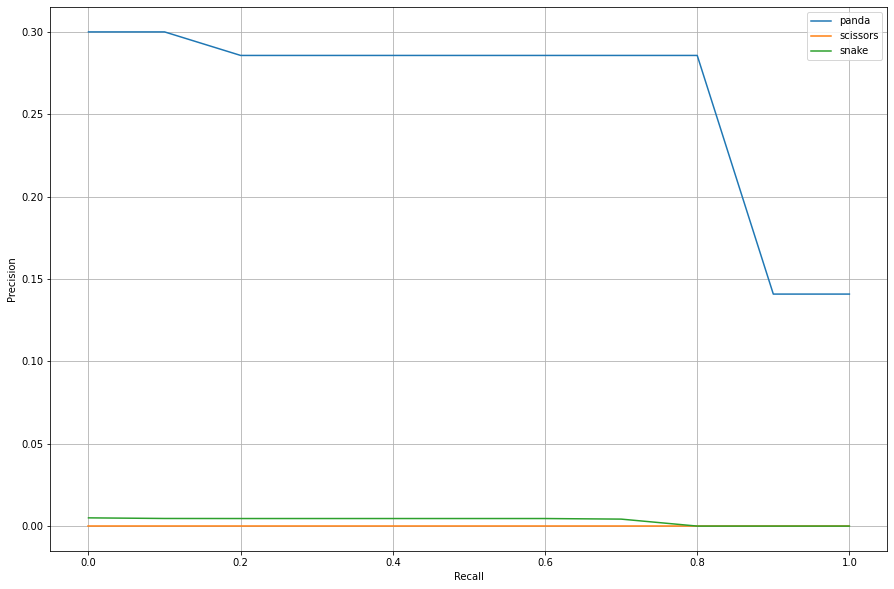

In [ ]:
# Training model with MultiBox loss function
training(
    clean_state=False,
    checkpoint_path=CHECKPOINT_PATH,
    log_path=LOG_PATH
)


[TRAINING] Epoch: 95 | Avg loss: 8.883967497409918
MODEL SAVED TO GOOGLE DRIVE
------
[VALIDATION] Epoch: 95 | Avg loss: 7.696764850616455
[VALIDATION] F1s: Panda = 0.14782609045505524; Scissors = 0.0; Snake = 0.11860941350460052 | Of last image only
[VALIDATION] APs: Panda = 0.11525093764066696; Scissors = 0.0; Snake = 0.05804326385259628 | mAP: 0.05776473507285118
------
[TRAINING] Epoch: 96 | Avg loss: 8.927705251253569
MODEL SAVED TO GOOGLE DRIVE
------
[VALIDATION] Epoch: 96 | Avg loss: 7.690800476074219
[VALIDATION] F1s: Panda = 0.16915422677993774; Scissors = 0.0625; Snake = 0.11824667453765869 | Of last image only
[VALIDATION] APs: Panda = 0.12424089759588242; Scissors = 0.032258063554763794; Snake = 0.05673515796661377 | mAP: 0.07107803970575333
------
[TRAINING] Epoch: 97 | Avg loss: 8.977521908588898
MODEL SAVED TO GOOGLE DRIVE
------
[VALIDATION] Epoch: 97 | Avg loss: 7.70453519821167
[VALIDATION] F1s: Panda = 0.15813954174518585; Scissors = 0.0555555522441864; Snake = 0.11

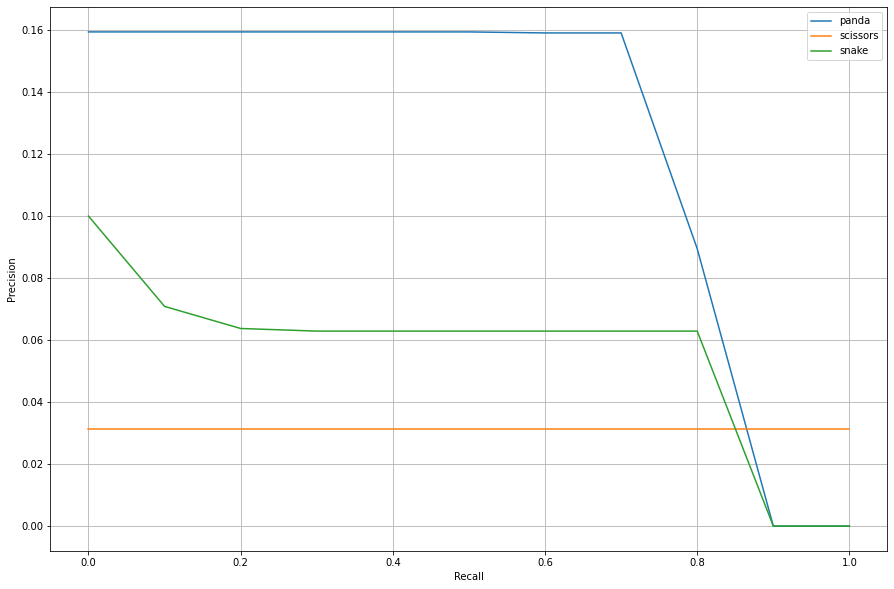

In [ ]:
# Training model with IoU-balanced loss function
training(
    clean_state=False,
    checkpoint_path=CHECKPOINT_PATH_IOU_BALANCED,
    log_path=LOG_PATH_IOU_BALANCED,
    use_multibox=False,
    lr=1e-5
)


# Testing

In [ ]:
def test(
    model,
    data_loader,
    loss_fn 
):
    losses, precisions, recalls, f1, precisions_t, recall_thresholds, APs, mAP = evaluate(model, data_loader, loss_fn)

    f1 = f1.cpu()

    print("[TEST] AP: Panda = {0}; Scissors = {1}; Snake = {2} | mAP: {3}"
        .format(APs[0], APs[1], APs[2], mAP))

    plt.rcParams['figure.figsize'] = [plot_width, plot_height]

    loss_ax = plt.axes(label="Loss")
    loss_ax.plot(losses)
    loss_ax.set_ylabel("Loss per batch")
    loss_ax.grid()
    plt.show(loss_ax)

    f1_ax = plt.axes(label="F1")
    f1_ax.plot(f1[0], label=rev_class_map[1])
    f1_ax.plot(f1[1], label=rev_class_map[2])
    f1_ax.plot(f1[2], label=rev_class_map[3])
    f1_ax.set_ylabel("F1 per image")
    f1_ax.legend()
    f1_ax.grid()
    plt.show(f1_ax)

    precision_recall_ax = plt.axes(label="Precision/Recall")
    for i, p in enumerate(precisions_t):
        precision_recall_ax.plot(recall_thresholds, p.to("cpu"), label=rev_class_map[i + 1])
    precision_recall_ax.set_xlabel("Recall")
    precision_recall_ax.set_ylabel("Precision per threshold")
    precision_recall_ax.legend()
    precision_recall_ax.grid()
    plt.show(precision_recall_ax)


[TEST] AP: Panda = 0.26623010635375977; Scissors = 0.08549187332391739; Snake = 0.0033401725813746452 | mAP: 0.11835405230522156


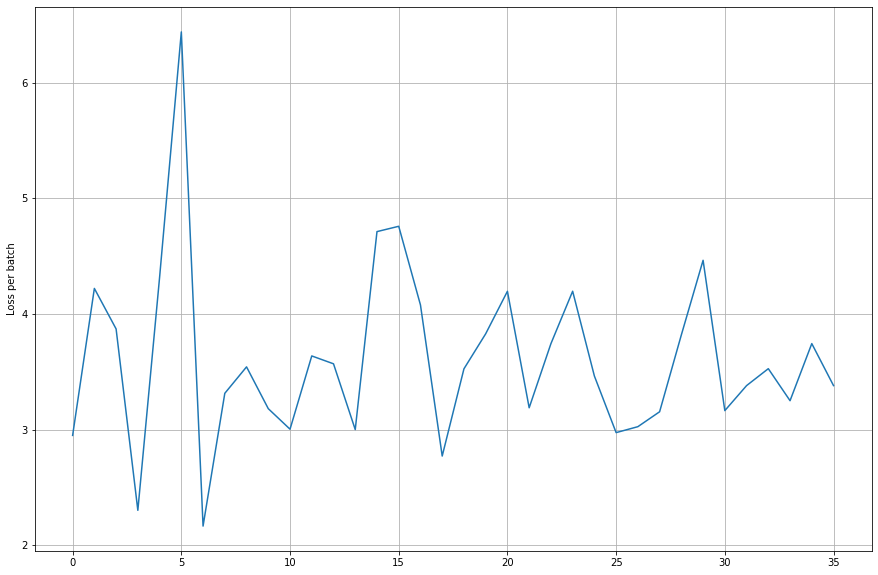

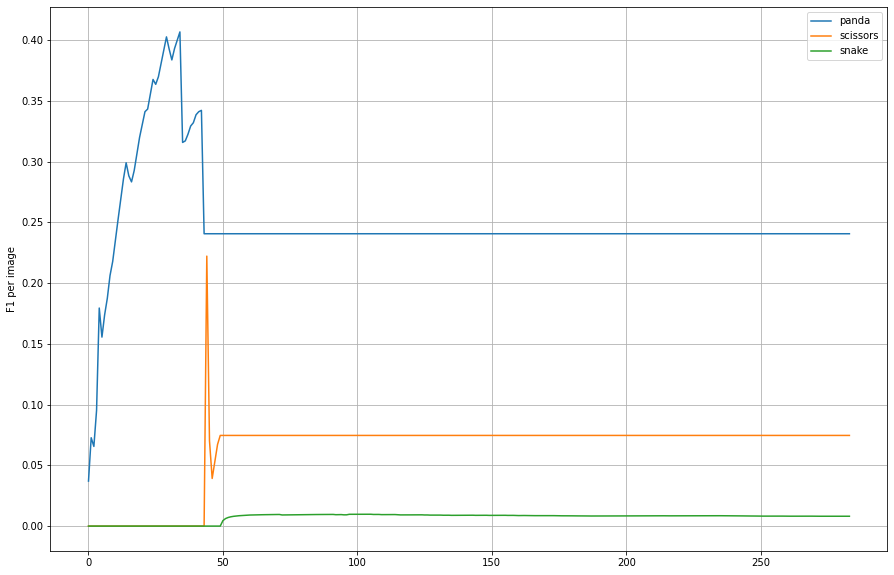

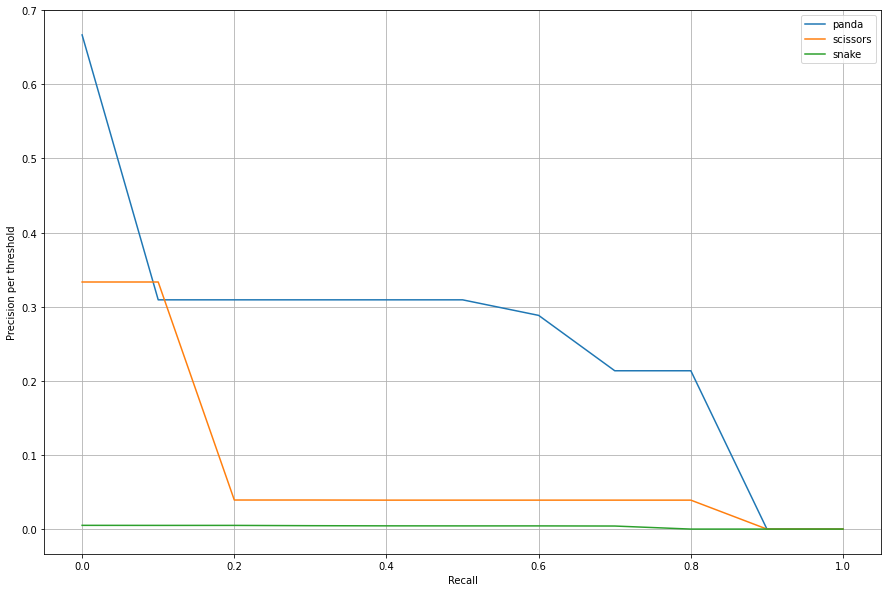

In [ ]:
# MultiBox testing
checkpoint = torch.load(CHECKPOINT_PATH)
model = checkpoint[STATE_MODEL].to(device)

batch_size = 8
workers = 2
test_dataset = OpenImagesDataset(TEST_DATA_PATH)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=workers,
    pin_memory=True
)
loss_fn = MultiBoxLoss(model.default_boxes_cxcy).to(device)

test(model, test_data_loader, loss_fn)

del test_dataset, test_data_loader, loss_fn, checkpoint, model

[TEST] AP: Panda = 0.10831183195114136; Scissors = 0.0719185397028923; Snake = 0.06246011704206467 | mAP: 0.08089683204889297


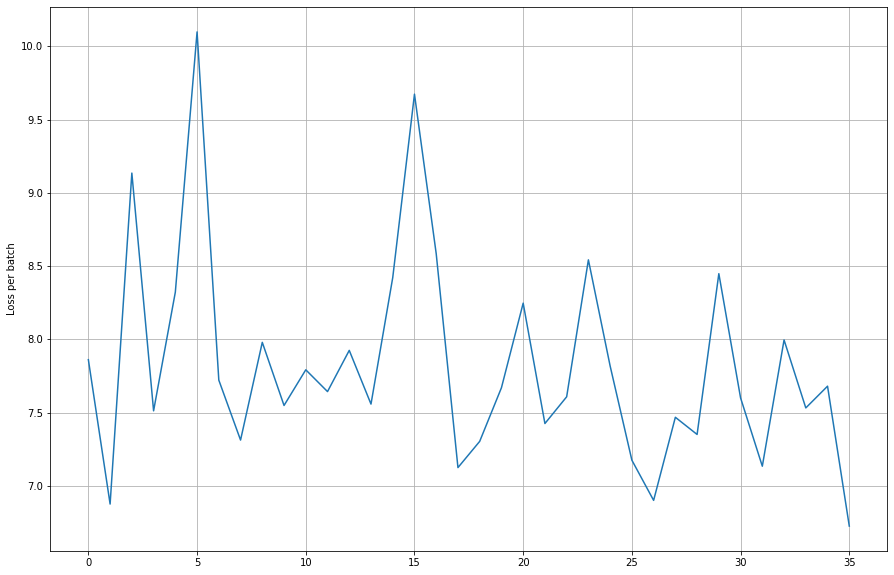

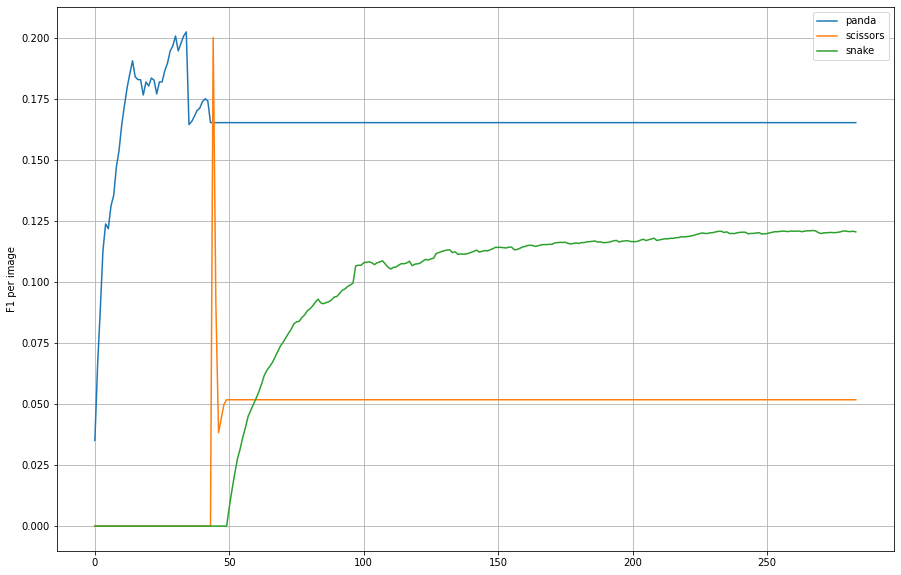

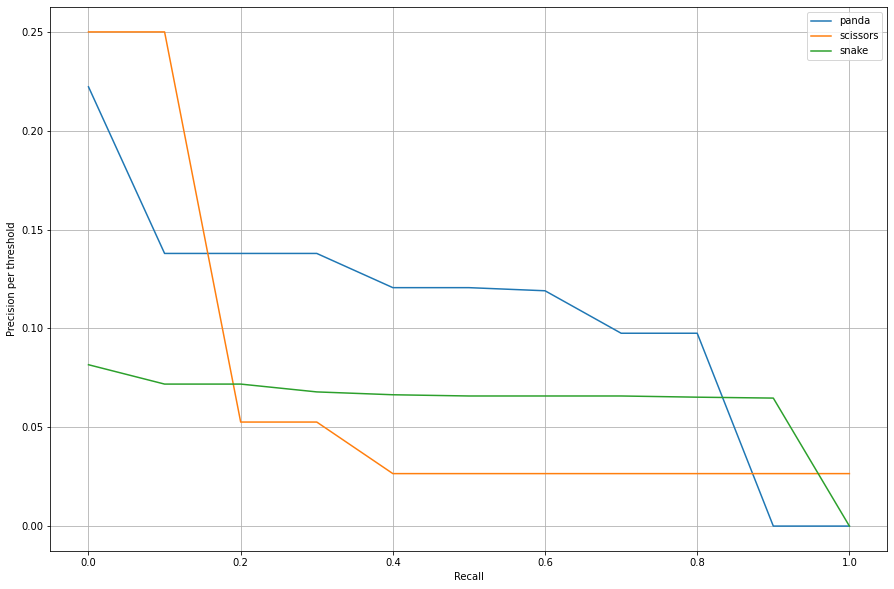

In [ ]:
# IoU-balanced testing
checkpoint = torch.load(CHECKPOINT_PATH_IOU_BALANCED)
model = checkpoint[STATE_MODEL].to(device)

batch_size = 8
workers = 2
test_dataset = OpenImagesDataset(TEST_DATA_PATH)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=workers,
    pin_memory=True
)
loss_fn = IoUbalancedLoss(model.default_boxes_cxcy).to(device)

test(model, test_data_loader, loss_fn)

del test_dataset, test_data_loader, loss_fn, checkpoint, model


# Detect objects in single image

In [ ]:
def detect_objects(model, image, return_image=True):
    resize = transforms.Resize((300, 300))
    to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

    transformed_image = normalize(to_tensor(resize(image))).to(device)

    pred_boxes_gcxgcy, predicted_scores = model(transformed_image.unsqueeze(0)) # add batch_size dim to image
    boxes_xy, labels, scores = decipher_predictions(
        model.default_boxes_cxcy,
        pred_boxes_gcxgcy,
        predicted_scores,
        min_score_threshold=0.2,
        max_overlap_threshold=0.45
    )

    # Remove batch_size dims
    boxes_xy = boxes_xy[0].detach().to("cpu")
    labels = [rev_class_map[l] for l in labels[0].tolist()]
    scores = scores[0].detach()

    original_dims = torch.FloatTensor([image.width, image.height, image.width, image.height]).unsqueeze(0)
    boxes_xy = boxes_xy * original_dims

    if not return_image:
        return boxes_xy, labels, scores

    if labels == [rev_class_map[0]]:
        return image
    
    annotated_image = image
    image_draw = ImageDraw.Draw(annotated_image)
    image_font = ImageFont.load_default()

    for i in range(boxes_xy.size(0)):
        box_location = boxes_xy[i].tolist()
        image_draw.rectangle(
            xy=box_location,
            outline=class_colors_map[labels[i]],
            width=3
        )

        text = labels[i].upper() + ": " + str(scores[i].item())

        text_size = image_font.getsize(text)
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,box_location[1]]
        image_draw.rectangle(
            xy=textbox_location,
            fill=class_colors_map[labels[i]]
        )
        image_draw.text(
            xy=text_location,
            text=text,
            fill="white",
            font=image_font
        )
        
    return annotated_image


Example of detections in single image

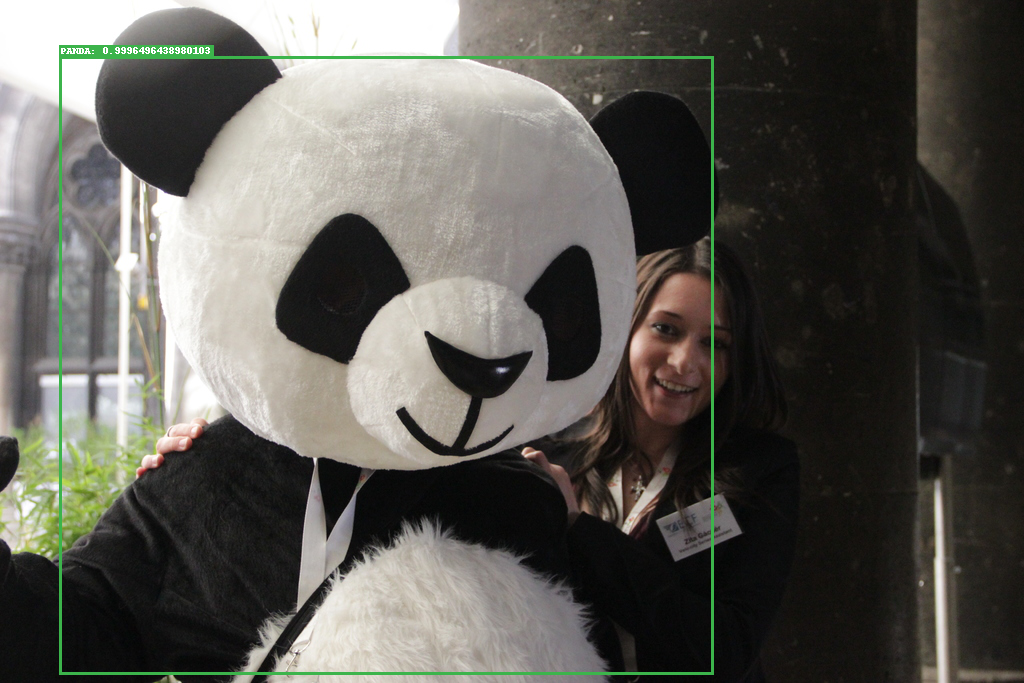

In [ ]:
checkpoint = torch.load(CHECKPOINT_PATH)
# checkpoint = torch.load(CHECKPOINT_PATH_IOU_BALANCED)
model = checkpoint[STATE_MODEL].to(device)
model.eval()

image = Image.open("/content/gdrive/MyDrive/SSD/image-data/test/panda/0397f06529bb385a.jpg", mode="r")
# image = Image.open("/content/gdrive/MyDrive/SSD/image-data/test/scissors/0353cfce0c0809e7.jpg", mode="r")
# image = Image.open("/content/gdrive/MyDrive/SSD/image-data/test/snake/00c64e1acd3a586b.jpg", mode="r")
image = image.convert("RGB")
annotated_image = detect_objects(model, image)
img_cvt = cvtColor(np.array(annotated_image), COLOR_RGB2BGR)
cv2_imshow(img_cvt)

del model, checkpoint


# REST API

In [ ]:
!pip install flask-ngrok


In [ ]:
from flask import Flask, request, jsonify, abort
from flask_ngrok import run_with_ngrok


In [ ]:
app = Flask(__name__)
run_with_ngrok(app)   

checkpoint = torch.load(CHECKPOINT_PATH)
model_classic = checkpoint[STATE_MODEL].to(device)
model_classic.eval()

checkpoint = torch.load(CHECKPOINT_PATH_IOU_BALANCED)
model_iou_balanced = checkpoint[STATE_MODEL].to(device)
model_iou_balanced.eval()

@app.route("/", methods=["GET"])
def home():
    return """
        <h3>Make a POST request on http://{api_id}.ngrok.io/api/detect/{model_type_query}</h3>
        <h4>Possible model types:</h4>
        <ul>
            <li>Classic SSD300: "/?model-type=classic"</li>
            <li>SSD300 with IoU-balanced: "/?model-type=iou-balanced"</li>
        </ul>
    """

@app.route("/api/detect/", methods=["POST"])
def detect():
    model_type = request.args.get("model-type", default="classic", type=str)

    model = None
    if model_type == "classic":
        model = model_classic
    elif model_type == "iou-balanced":
        model = model_iou_balanced
    else:
        abort(400)

    image = request.files["image"]
    image = Image.open(image)

    boxes_xy, labels, scores = detect_objects(model, image, return_image=False)

    return jsonify(
        boxes_xy=boxes_xy.tolist(),
        labels=labels,
        scores=scores.tolist()
    )

app.run()


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://090480504338.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [14/Apr/2021 15:37:24] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [14/Apr/2021 15:37:25] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [14/Apr/2021 15:37:37] "POST /api/detect/?model-type=classic HTTP/1.1" 200 -
127.0.0.1 - - [14/Apr/2021 15:38:06] "POST /api/detect/?model-type=classic HTTP/1.1" 200 -
